Martina Carretta (1673930), Meritxell Carvajal (1671647)

In [1]:
import cv2
import urllib3
import numpy as np

from PIL import Image

import imutils
from matplotlib import pyplot as plt

# Block 4. Feature detection, Image descriptors and BoVW

This lab explores the fundamental concepts of feature extraction and feature descriptors in computer vision. It delves into various feature detection techniques like Harris corner and LoG blob detectors, and descriptor methods like SIFT, SURF, and ORB. Additionally, the lab introduces the Bag of Visual Words model, demonstrating its application in image classification, particularly using a subset of the VOC dataset.

### Objectives:
1. **Implement Feature extraction methods**
  - **Implement Harris Corner Detector**: Understand and implement the Harris corner detection algorithm to identify corner features in images.
  - **Implement LoG Blob Detector**: Learn and apply the Laplacian of Gaussian method for blob detection in images.
2. **Implement Image feature descriptors** (Reusing part of the feature extraction code)
  - **Implement Normalized Color Histogram and Color Space Changes**: Explore color features by implementing normalized color histograms and understanding the impact of different color spaces.
  - **Use SIFT, SURF, and ORB**: Use these feature descriptors, analyze their strengths and weaknesses, and compare their performance.
3. **Provide a Pipeline for Bag of Words and Compute Results on Subset of VOC Dataset**: Develop a Bag of Visual Words model and test its efficacy in classifying images from a subset of the VOC dataset.

---

### Mandatory Questions:

1. Explain the principles behind corner detectors, specifically the Harris corner detection method. Why is it effective in identifying corners?
2. Discuss the main differences between edge detection and corner detection. Why are corners considered more robust features?
3. What are the limitations of the Harris corner detector in complex images?
4. Describe the Laplacian of Gaussian blob detector. How does it differ from edge detection?
5. Discuss the role of feature descriptors in object recognition.
6. Why are color histograms useful for image feature extraction? Describe the process of creating a normalized color histogram.
7. How does a change in color space affect feature extraction in images?
8. Explain the concepts of scale and rotation invariance in feature detection. For each algorithm (SIFT, SURF, and ORB), explain how they handle scale and rotation variations in images.
9. Compare SIFT, SURF, and ORB in terms of computational efficiency and accuracy.
10. What is the role of orientation assignment in the SIFT algorithm?
11. How does the ORB algorithm differ from SIFT and SURF in terms of feature matching?
12. How do feature descriptors contribute to the process of image stitching (for panorama images)?
13. Discuss the impact of varying lighting conditions on feature detection and description. How can these challenges be mitigated?
14. What are the key steps in constructing a Bag of Visual Words model? Explain each of them in detail.
15. In the context of the Bag of Visual Words model, explain the significance of feature quantization. Discuss on which steps it can be done and how it affects the results.


### Optional Deep Dive Questions:

1. Discuss the potential weaknesses of the LoG blob detector in real-world scenarios. Propose improvements.
2. Explore the potential of hybrid color spaces (combining properties of different color models) in improving the robustness of feature extraction for applications in varied lighting and environmental conditions.
3. Discuss the impact of varying image resolutions on the effectiveness of feature descriptors.
4. Discuss the limitations of current feature descriptors in handling occlusions and propose potential improvements.
5. Evaluate the performance of hybrid feature detectors that combine the properties of multiple algorithms (like SIFT and Harris). What are the potential benefits?
6. Analyze the role of feature extraction in content-based image retrieval systems. How do they impact the efficiency and accuracy of searches?
7. How might the Bag of Visual Words model be modified or extended to improve classification accuracy?
8. Consider the role of context in feature-based image classification. How might contextual information be incorporated into the Bag of Visual Words model?


### Exercise 1: Harris Corner Detector Implementation
**Objective**:

Implement the Harris Corner Detection algorithm to identify corner features in images.

**Guideline**:
- Load image.
- Implement the basic Harris Corner Detection algorithm.
- Apply the algorithm to the images and visualize the detected corners.
- Explore the impact of parameter changes on detection quality.
- (Optional) Implement the Harris-Laplace and the Harris-Affine improvments and compare the pros and cons of each version

**Expected Results**:
- A working Harris Corner Detection implementation.
- Visualization of corner detection in various images.

In [2]:
# Modified convolution so that it does symmetric padding
def convolution(img, kernel):
    # Reverse the kernel
    flipped_kernel = np.flipud(np.fliplr(kernel))
    
    # Calculate dimensions of the output
    output_h = img.shape[0]
    output_w = img.shape[1]
    
    # Pad the image with symmetric padding
    padded_image = np.pad(img, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='reflect')
    
    # Create output with zeros
    output = np.zeros((output_h, output_w))
    
    # Apply the convolution operation manually
    for i in range(output_h):
        for j in range(output_w):
            output[i, j] = np.sum(padded_image[i:i+kernel.shape[0], j:j+kernel.shape[1]] * flipped_kernel)
    
    return output


In [3]:
def gradient_x(img):
    kernel = np.array([[-1, 0, 1]])
    output = convolution(img, kernel)
    return output

def gradient_y(img):
    kernel = np.array([[-1], [0], [1]])  # Transposed kernel
    output = convolution(img, kernel)
    return output

def harris_corner_detection(img, window_size=3, k=0.04, threshold = 0.3):
    # Compute x and y derivatives of the image
    Ix = gradient_x(img)
    Iy = gradient_y(img)

    # Form matrices
    Ixx = np.square(Ix)
    Ixy = Iy*Ix
    Iyy = np.square(Iy)
    
    Ixx = cv2.GaussianBlur(Ixx, (3, 3), 0.01)
    Ixy = cv2.GaussianBlur(Ixy, (3, 3), 0.01)
    Iyy = cv2.GaussianBlur(Iyy, (3, 3), 0.01)

    height, width = img.shape
    corner_list = []
    r = np.zeros_like(img, dtype=np.float64)  # Harris response for each pixel

    for y in range(window_size, height-window_size):
        for x in range(window_size, width-window_size):
            # Sums of products of derivatives (M matric)
            Sxx = np.sum(Ixx[y-window_size:y+window_size+1, x-window_size:x+window_size+1])
            Sxy = np.sum(Ixy[y-window_size:y+window_size+1, x-window_size:x+window_size+1])
            Syy = np.sum(Iyy[y-window_size:y+window_size+1, x-window_size:x+window_size+1])

            # Formula (Response R function)
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r[y, x] = det - k*(trace**2)

    # Normalize the Harris responses
    cv2.normalize(r, r, 0, 1, cv2.NORM_MINMAX)

    # Non-maximum suppression (avoid overlapping)
    corners = []
    for y in range(window_size, height-window_size):
        for x in range(window_size, width-window_size):
            if r[y, x] == np.max(r[y-window_size:y+window_size+1, x-window_size:x+window_size+1]) and r[y, x] > threshold:
                corners.append([x, y, r[y, x]])

    return corners

def draw_corners(image, corners, color=(0, 0, 255)):
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for corner in corners:
        x, y, r = corner
        cv2.circle(color_image, (x, y), 2, color, -1)
    return color_image

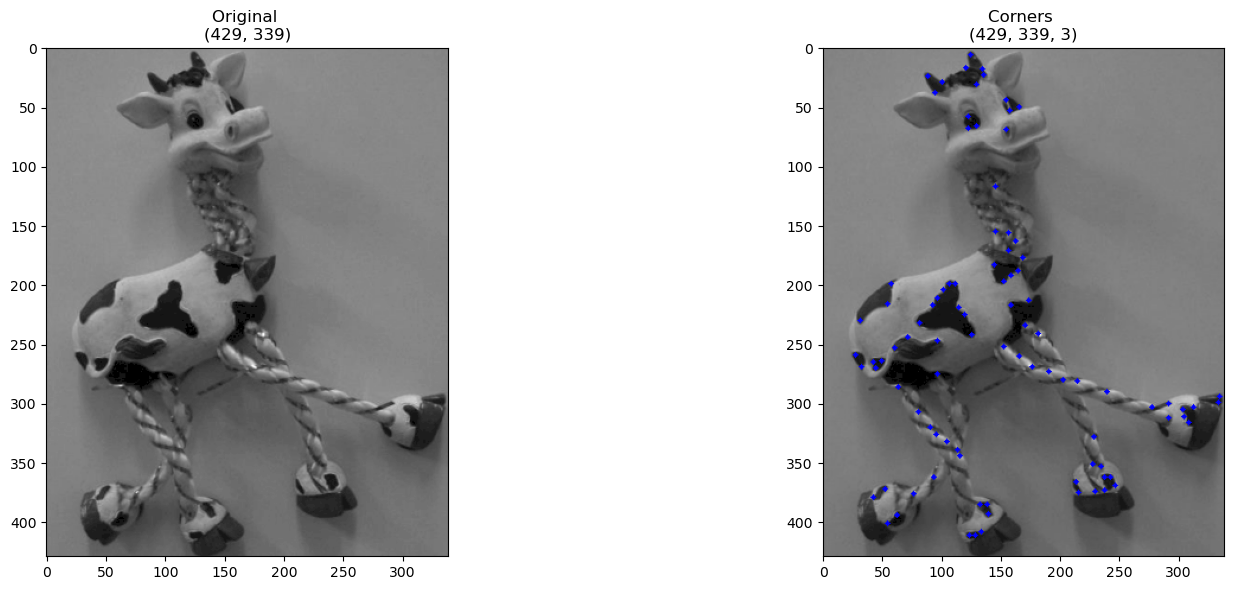

In [4]:
# Load images
og = cv2.imread('./harris.png', 0)

# Detect corners
corners = harris_corner_detection(og, threshold = 0.10)

# Draw corners on images
img = draw_corners(og, corners)

# Display the images with corners detected
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].imshow(og, cmap="gray")
axes[0].set_title("Original \n" + str(og.shape))
axes[1].imshow(img)
axes[1].set_title("Corners \n" + str(img.shape))

plt.tight_layout()
plt.show()

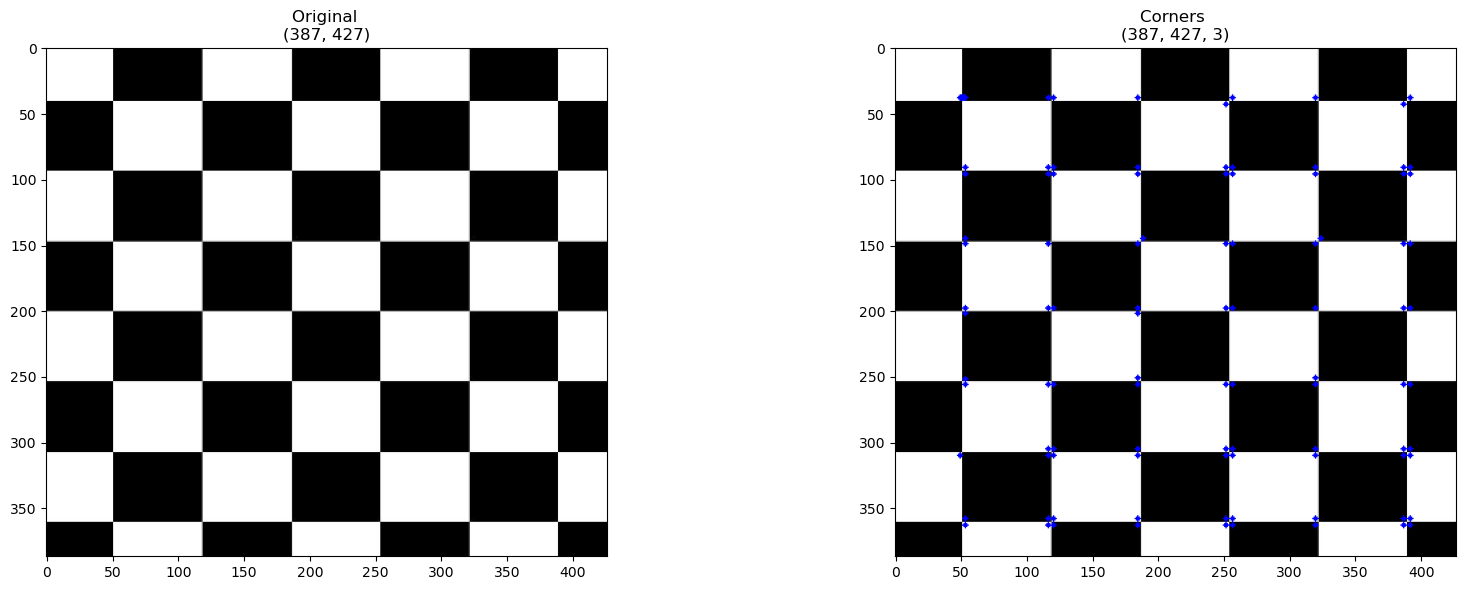

In [5]:
# Load images
og2 = cv2.imread('./harris2.png', 0)

# Detect corners
corners2 = harris_corner_detection(og2, threshold = 0.1)

# Draw corners on images
img2 = draw_corners(og2, corners2)

# Display the images with corners detected
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].imshow(og2, cmap="gray")
axes[0].set_title("Original \n" + str(og2.shape))
axes[1].imshow(img2)
axes[1].set_title("Corners \n" + str(img2.shape))

plt.tight_layout()
plt.show()

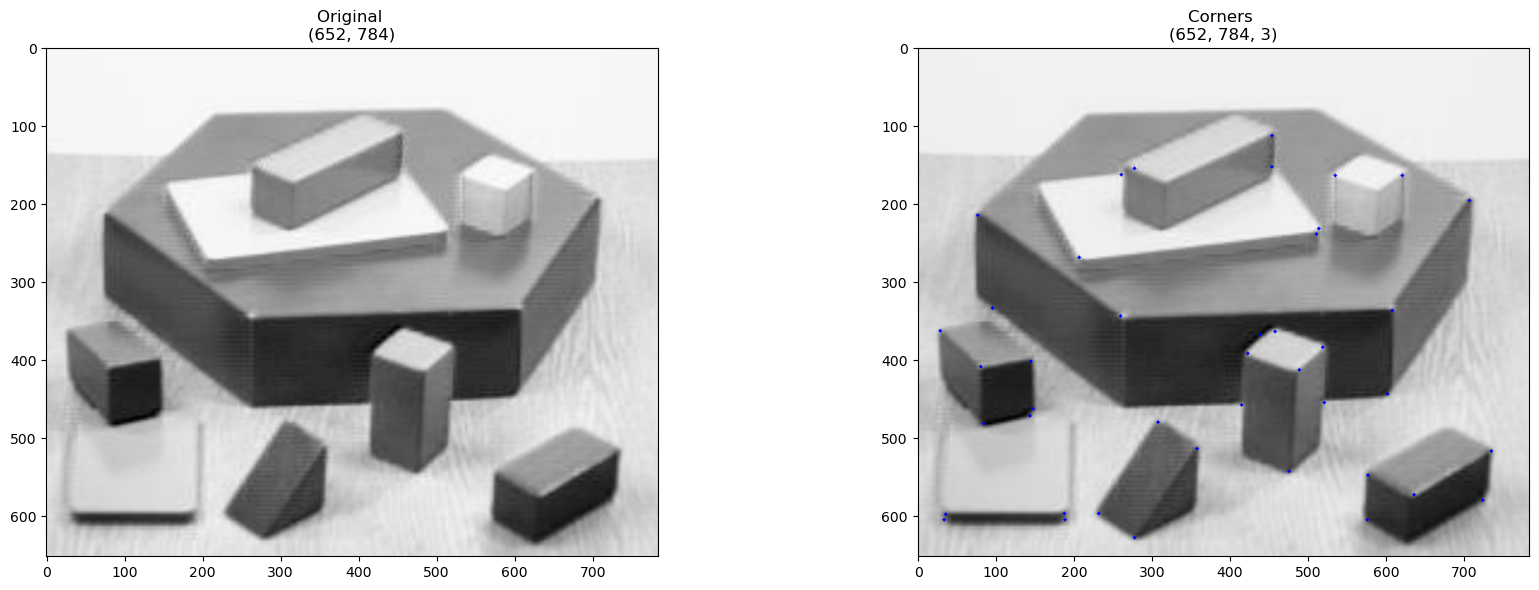

In [6]:
# Load images
og3 = cv2.imread('./harris3.png', 0)

# Detect corners
corners3 = harris_corner_detection(og3, threshold = 0.45)

# Draw corners on images
img3 = draw_corners(og3, corners3)

# Display the images with corners detected
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].imshow(og3, cmap="gray")
axes[0].set_title("Original \n" + str(og3.shape))
axes[1].imshow(img3)
axes[1].set_title("Corners \n" + str(img3.shape))

plt.tight_layout()
plt.show()

Changing the threshold we change how many of them we count as corners. This needs to be changed according to each image's properties as seen in these 3 examples.

The window_size defines the size of the neighborhood window used for computing the gradient and second-moment matrix. A larger window considers a broader region around each pixel, which can lead to smoother results and handle larger corner structures. However, it might miss smaller corners. On the other hand, a smaller window focuses on finer details but may be sensitive to noise.
Adjusting window_size involves a trade-off between sensitivity to small corners and robustness to noise.

The parameter k is a constant factor that influences the sensitivity of the corner detector. It is used in the Harris response calculation, where higher values of k make the algorithm more selective in identifying corners. Typically, values like 0.04 or 0.06 are used.
Increasing k makes the algorithm more selective in identifying corners, and decreasing it makes it less selective.


### Exercise 2: LoG Blob Detector Implementation
**Objective**:

Develop and apply the LoG method for blob detection in images, understanding its application in feature extraction.

**Guideline**:
- Select diverse images for blob detection.
- Implement the LoG Blob Detector.
- Analyze the LoG method's effectiveness.
- Compare LoG with other blob detection methods.
- (Optional) Implement your own version of other methods (DoG, DoH, ...) or design your own

**Expected Results**:
- Documented LoG Blob Detector implementation.
- Comparative analysis of blob detection results.
- Evaluation of method effectiveness and limitations.


In [7]:
from scipy.ndimage import gaussian_laplace

def detect_blobs(image, sigma = 3, threshold = 100):
    i = image.copy()
    # Apply LoG
    log_image = gaussian_laplace(i, sigma)
    log_image = np.abs(log_image)

    # Create a binary image where the blobs are white and everything else is black
    _, thresholded = cv2.threshold(log_image, threshold, 255, cv2.THRESH_BINARY_INV)

    # Find boundaries of the blobs
    contours, _ = cv2.findContours(thresholded.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # So that we can draw in red
    color_image = cv2.cvtColor(i, cv2.COLOR_GRAY2BGR)

    # Draw blobs on the image
    for contour in contours:
        # Calculate the area of the blob
        area = cv2.contourArea(contour)

        # Calculate the center of the blob
        moments = cv2.moments(contour)
        if moments["m00"] != 0: # If the contour has area
            cX = int(moments["m10"] / moments["m00"]) # x component of the center
            cY = int(moments["m01"] / moments["m00"]) # y component of the center

            # Draw circle in red
            cv2.circle(color_image, (cX, cY), int(np.sqrt(area/np.pi)), (0, 0, 255), 2)
    return color_image

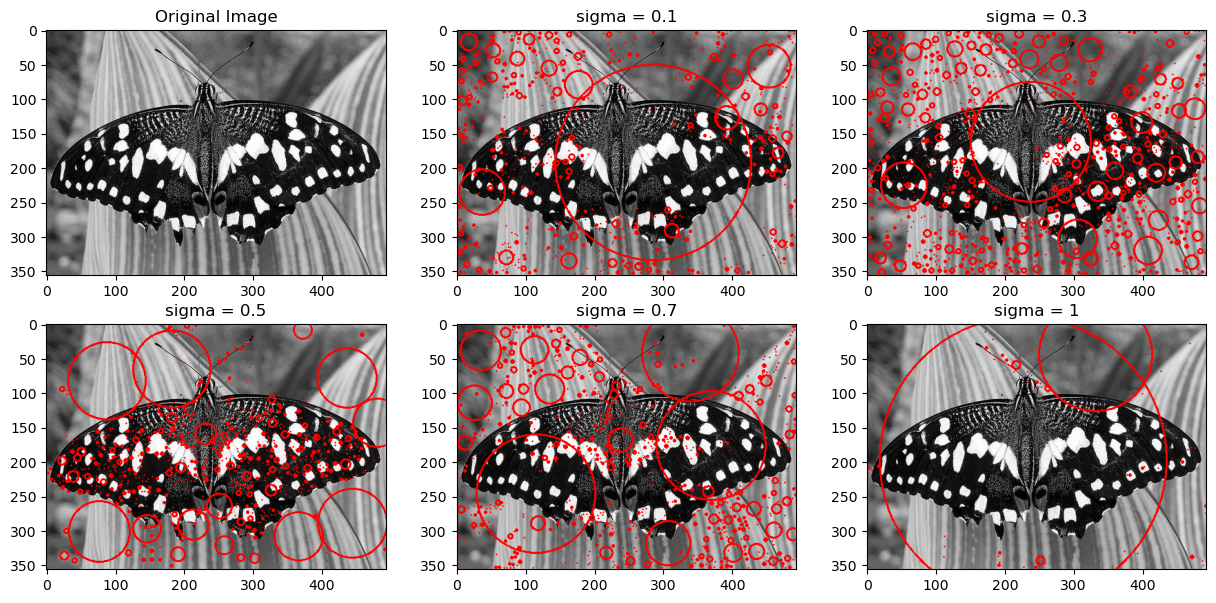

In [8]:
# Load image
image = cv2.imread('./LoG.jpg', 0)
i = detect_blobs(image, 0.1)
i2 = detect_blobs(image, 0.3)
i3 = detect_blobs(image, 0.5)
i4 = detect_blobs(image, 0.7)
i5 = detect_blobs(image, 1)


# Display the results
fig, axes = plt.subplots(2, 3, figsize=(15, 7))

axes[0][0].imshow(image, cmap='gray')
axes[0][0].set_title('Original Image')
axes[0][1].imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
axes[0][1].set_title('sigma = 0.1')
axes[0][2].imshow(cv2.cvtColor(i2, cv2.COLOR_BGR2RGB))
axes[0][2].set_title('sigma = 0.3')

axes[1][0].imshow(cv2.cvtColor(i3, cv2.COLOR_BGR2RGB))
axes[1][0].set_title('sigma = 0.5')
axes[1][1].imshow(cv2.cvtColor(i4, cv2.COLOR_BGR2RGB))
axes[1][1].set_title('sigma = 0.7')
axes[1][2].imshow(cv2.cvtColor(i5, cv2.COLOR_BGR2RGB))
axes[1][2].set_title('sigma = 1')

plt.show()

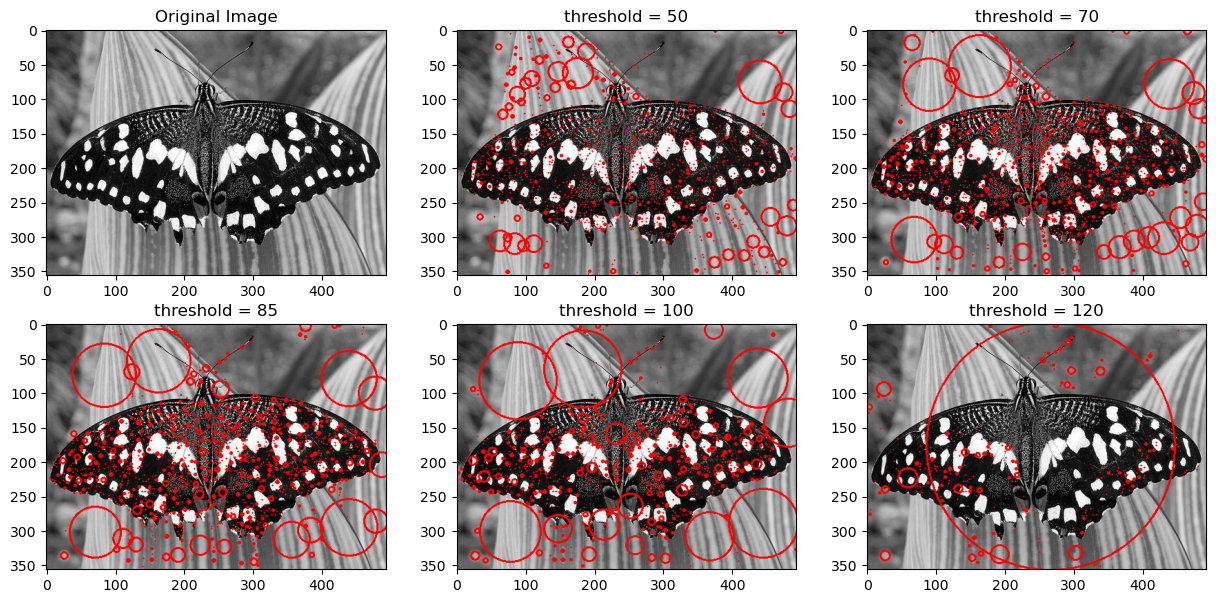

In [9]:
# Load image
i = detect_blobs(image, 0.5, 50)
i2 = detect_blobs(image, 0.5, 70)
i3 = detect_blobs(image, 0.5, 85)
i4 = detect_blobs(image, 0.5, 100)
i5 = detect_blobs(image, 0.5, 120)


# Display the results
fig, axes = plt.subplots(2, 3, figsize=(15, 7))

axes[0][0].imshow(image, cmap='gray')
axes[0][0].set_title('Original Image')
axes[0][1].imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
axes[0][1].set_title('threshold = 50')
axes[0][2].imshow(cv2.cvtColor(i2, cv2.COLOR_BGR2RGB))
axes[0][2].set_title('threshold = 70')

axes[1][0].imshow(cv2.cvtColor(i3, cv2.COLOR_BGR2RGB))
axes[1][0].set_title('threshold = 85')
axes[1][1].imshow(cv2.cvtColor(i4, cv2.COLOR_BGR2RGB))
axes[1][1].set_title('threshold = 100')
axes[1][2].imshow(cv2.cvtColor(i5, cv2.COLOR_BGR2RGB))
axes[1][2].set_title('threshold = 120')

plt.show()

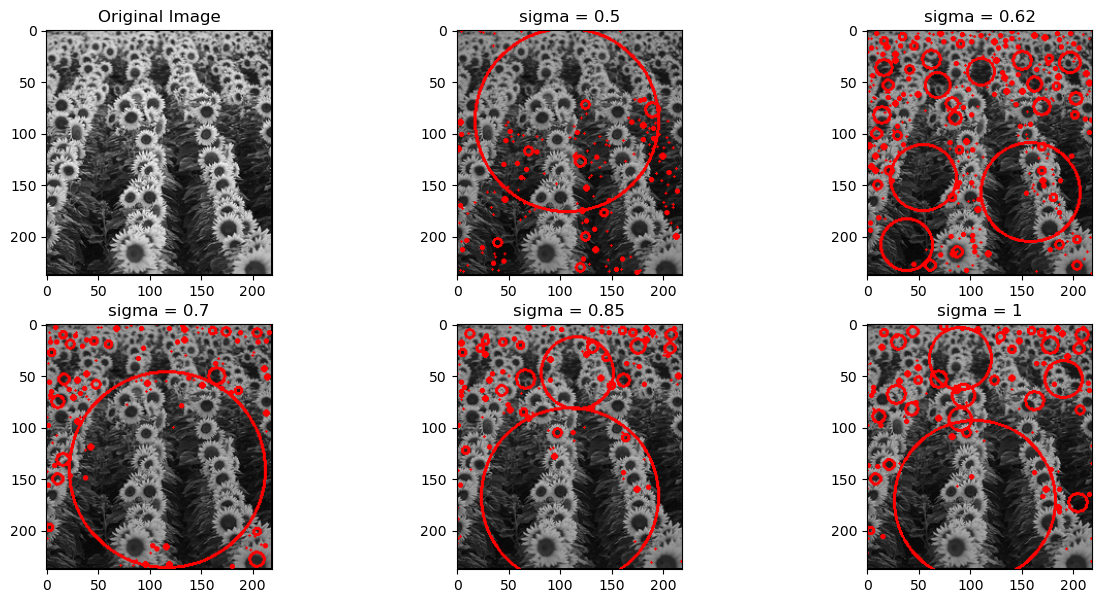

In [10]:
# Load image
image = cv2.imread('./log.png', 0)
i = detect_blobs(image, 0.5)
i2 = detect_blobs(image, 0.62)
i3 = detect_blobs(image, 0.7)
i4 = detect_blobs(image, 0.85)
i5 = detect_blobs(image, 1)


# Display the results
fig, axes = plt.subplots(2, 3, figsize=(15, 7))

axes[0][0].imshow(image, cmap='gray')
axes[0][0].set_title('Original Image')
axes[0][1].imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
axes[0][1].set_title('sigma = 0.5')
axes[0][2].imshow(cv2.cvtColor(i2, cv2.COLOR_BGR2RGB))
axes[0][2].set_title('sigma = 0.62')

axes[1][0].imshow(cv2.cvtColor(i3, cv2.COLOR_BGR2RGB))
axes[1][0].set_title('sigma = 0.7')
axes[1][1].imshow(cv2.cvtColor(i4, cv2.COLOR_BGR2RGB))
axes[1][1].set_title('sigma = 0.85')
axes[1][2].imshow(cv2.cvtColor(i5, cv2.COLOR_BGR2RGB))
axes[1][2].set_title('sigma = 1')

plt.show()

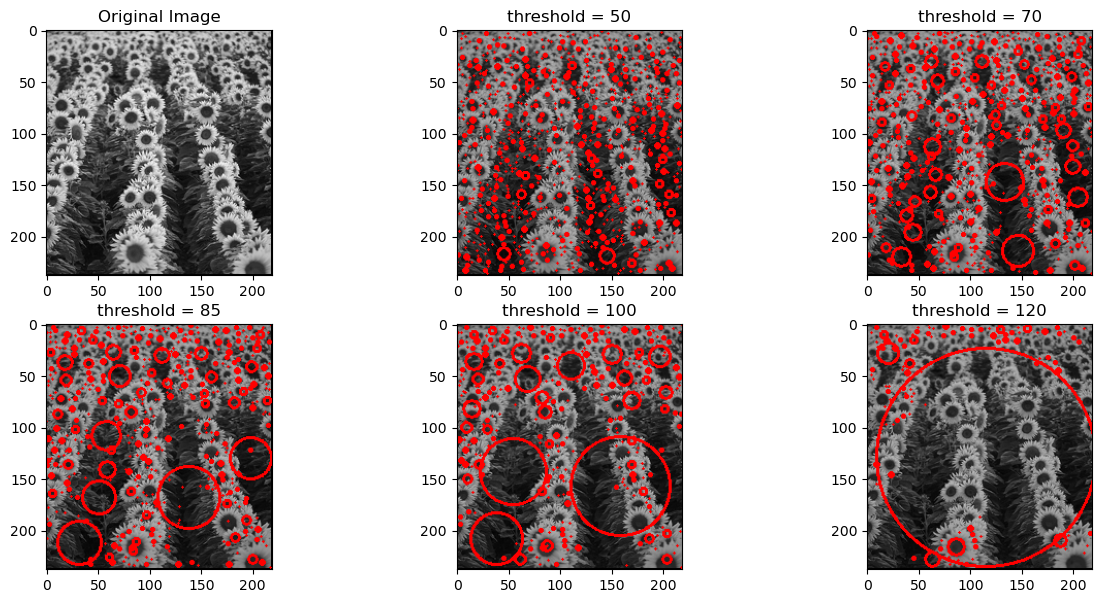

In [11]:
i = detect_blobs(image, 0.62, 50)
i2 = detect_blobs(image, 0.62, 70)
i3 = detect_blobs(image, 0.62, 85)
i4 = detect_blobs(image, 0.62, 100)
i5 = detect_blobs(image, 0.62, 120)


# Display the results
fig, axes = plt.subplots(2, 3, figsize=(15, 7))

axes[0][0].imshow(image, cmap='gray')
axes[0][0].set_title('Original Image')
axes[0][1].imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
axes[0][1].set_title('threshold = 50')
axes[0][2].imshow(cv2.cvtColor(i2, cv2.COLOR_BGR2RGB))
axes[0][2].set_title('threshold = 70')

axes[1][0].imshow(cv2.cvtColor(i3, cv2.COLOR_BGR2RGB))
axes[1][0].set_title('threshold = 85')
axes[1][1].imshow(cv2.cvtColor(i4, cv2.COLOR_BGR2RGB))
axes[1][1].set_title('threshold = 100')
axes[1][2].imshow(cv2.cvtColor(i5, cv2.COLOR_BGR2RGB))
axes[1][2].set_title('threshold = 120')

plt.show()

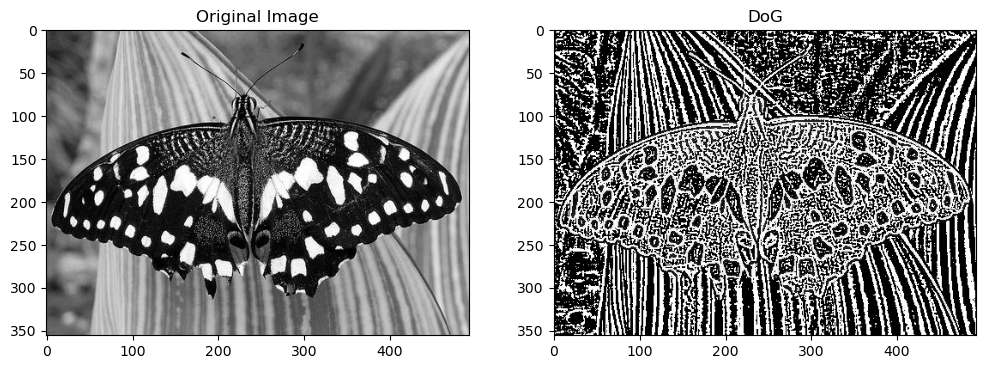

In [12]:
def DoG(image, sigma1, sigma2):
    g1 = cv2.GaussianBlur(image, (5, 5), sigma1)
    g2 = cv2.GaussianBlur(image, (5, 5), sigma2)
    return g1 - g2

# Load image
image = cv2.imread('./LoG.jpg', 0)
i = DoG(image, 1, 3)

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
axes[1].set_title('DoG')

plt.show()

LoG is a widely used technique for edge detection.

LoG is effective at detecting edges. Edges often correspond to the boundaries of objects within an image, making them useful for tasks such as object recognition and segmentation.
It is often applied to an image that has first been smoothed with a Gaussian filter. This helps to reduce its sensitivity to noise. It can also reveal spatial patterns.

Even with these positive aspects, LoG involves a convolution, which can be computationally expensive.
The effectiveness of the LoG method can depend on the selection of the sigma parameter for the Gaussian smoothing. This parameter may need to be adjusted based on the image.


### Exercise 3: Normalized Color Histogram and Color Space Changes
**Objective**:
Implement normalized color histograms and explore color space transformations' impact on feature extraction.

**Guideline**:
- Implement normalized color histograms.
- Transform images into different color spaces and generate histograms.
- Analyze the impact of color space changes.

**Expected Results**:
- Color histograms in various spaces for a set of images.
- Comparative analysis on color space impact.
- Discussion on color in feature extraction and analysis.



In [13]:
# Paths and names
image_paths = ['./histo.jpg', './histo2.jpg', './histo3.jpg', './histo4.jpg']
names = ['Mountain landscape', 'TD Garden', 'Wolves', 'NY Skyline']

# Put resized images in list
images = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    image = cv2.resize(image, (400, 250))  # Resize the image
    images.append(image)

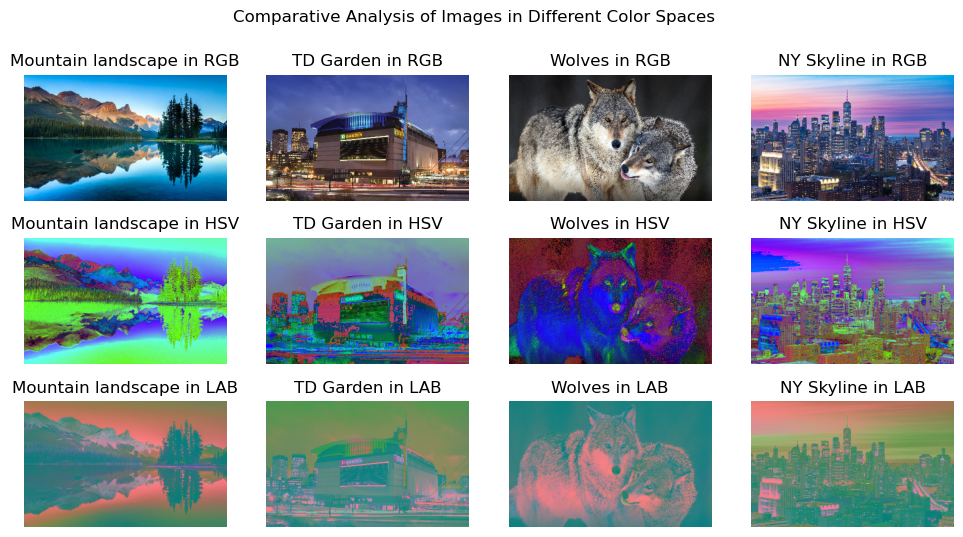

In [14]:
def show_images_in_color_spaces(images, names, color_spaces=['RGB', 'HSV', 'LAB']):
    # Create grid with subplots
    fig, axes = plt.subplots(3, 4, figsize=(12, 6))

    # Iterate over color spaces
    for j, color_space in enumerate(color_spaces):
        for i, (image, name) in enumerate(zip(images, names)): # Iterate through images and names
            image_in_color_space = cv2.cvtColor(image, getattr(cv2, f'COLOR_BGR2{color_space}'))
            axes[j, i].imshow(image_in_color_space)
            axes[j, i].set_title(f'{name} in {color_space}')
            axes[j, i].axis('off')  # Turn off axis for image plots

    # Display the title for the entire set of plots
    plt.suptitle('Comparative Analysis of Images in Different Color Spaces')
    plt.show()

show_images_in_color_spaces(images, names)

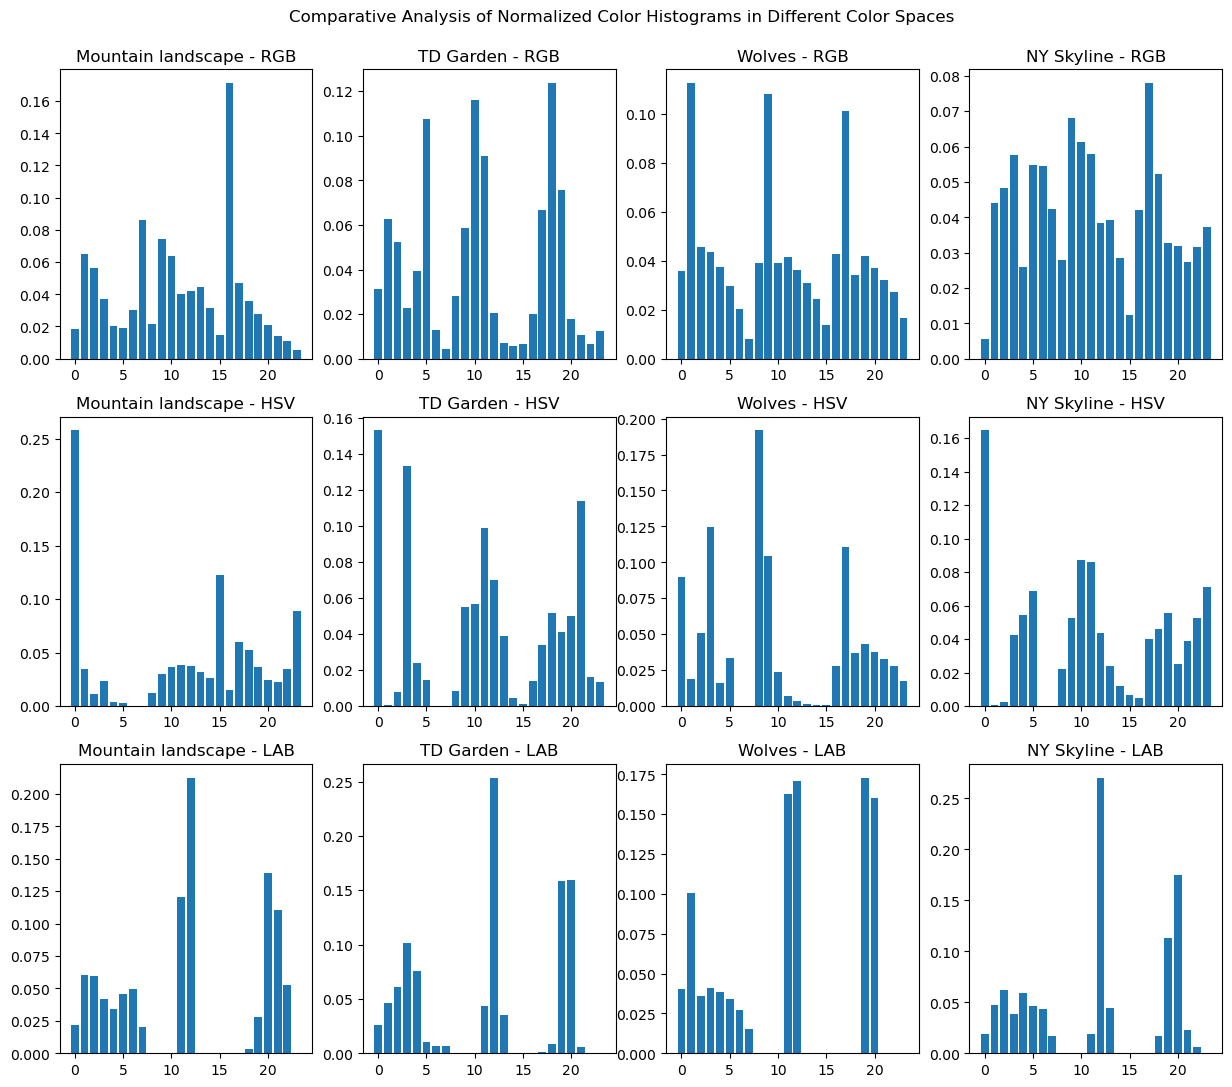

In [15]:
def compute_normalized_histogram(image, color_space='RGB', bins=8):
    # Convert image to the specified color space
    if color_space != 'RGB':
        image = cv2.cvtColor(image, getattr(cv2, f'COLOR_RGB2{color_space}'))

    # Calculate histogram for each channel
    hist_channels = [np.histogram(image[:, :, i], bins=bins, range=(0, 256))[0] for i in range(image.shape[2])]

    # Concatenate histograms into a single feature vector
    histogram = np.concatenate(hist_channels)

    # Normalize the histogram
    histogram = histogram / np.sum(histogram)

    return histogram

def plot_color_histograms(images, names, color_spaces=['RGB', 'HSV', 'LAB'], bins=8):
    # Create grid with subplots
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))

    # Iterate over color spaces
    for j, color_space in enumerate(color_spaces):
        for i, (image, name) in enumerate(zip(images, names)):
            histogram = compute_normalized_histogram(image, color_space, bins)
            axes[j, i].bar(range(len(histogram)), histogram)
            axes[j, i].set_title(f'{name} - {color_space}')

    # Display the title for the entire set of plots
    plt.suptitle('Comparative Analysis of Normalized Color Histograms in Different Color Spaces')
    plt.subplots_adjust(top=0.93)
    plt.show()

plot_color_histograms(images, names)

While color may not always be the main afpect in feature extraction, it is a fundamental one for several reasons:

Firstly, the most obvious reason is that in many cases, color can help differentiate objects in an image as usually it separates objects or areas. For instance, in a picture of a garden, the green color can help identify plants, while the blue color can help identify the sky. In object recognition, color can provide important information that helps identify specific objects.

Additionally, color can be used in texture analysis. The variation of color in an image can provide information about the texture of the objects in the image.

Color can also give clues about the illumination conditions when the image was taken. This can be useful in adjusting the image for better visibility or for further processing.

The decision to convert an image to a different color space depends on the specific task or application at hand.

1. **RGB (Red, Green, Blue)**: This is the most common color space. It consists of additive color mixing between the 3 channels. The range is [0-255] per channel in 8-bit depth. However, it doesn't have perceptual uniformity.

2. **CMYK (Cyan, Magenta, Yellow, Key/Black)**: This is a subtractive color space used in color printing. Colors are made by subtracting light. 

3. **HSV (Hue, Saturation, Value)**: This color space describes colors in terms more aligned with human perception. It represents colors in hue, saturation and value. Its range is [0-360]º for the hue and [0-100]% for the saturation and the value. This colorspace doesn't have perceptual uniformity either

4. **Lab**: This color space includes all perceivable colors. It's perceptually uniform, with L* for lightness, and a and b for color-opponent dimensions. The range is [0-100] for L, [-128 - +127] for a and b.

5. **Grayscale**: This color space represents image intensity (brightness) only. It's used when color information is not necessary or when you want to simplify an image for tasks like object detection, edge detection, or texture analysis.

When talking about image processing descriptors, RGB works well with images that have consistent illumination. 
The HSV color space separates color information (Hue) from intensity or lighting information (Saturation and Value). This makes HSV a good choice for tasks where color is important but lighting conditions can vary. For example, HSV is often used in skin detection because the hue channel captures the color of the skin, while the saturation and value channels can account for different lighting conditions.
The Lab color space is designed to be perceptually uniform, meaning that a given change in a color value should produce a change of about the same visual importance. 

### Exercise 4: Implementation and Analysis of SIFT, SURF, and ORB
**Objective**:
Implement and analyze SIFT, SURF, and ORB feature descriptors (use opencv implementations), understanding their pros and cons.

**Guideline**:
- Select a diverse image dataset.
- Implement SIFT and ORB algorithms. (Since SURF is patented, is optionally in the comparions)
- Apply these methods to some images.

**Expected Results**:
- Implementations of SIFT, ORB (and SURF).
- Hyperparameter analysis of each algorithm.
- Comparision of the methods

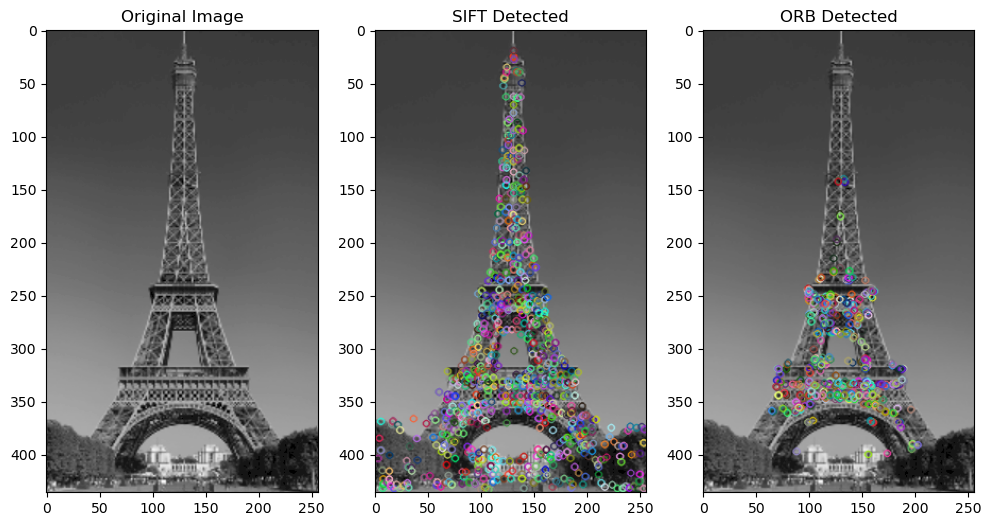

In [16]:
image = cv2.imread('./sift.png', cv2.IMREAD_GRAYSCALE)

# SIFT
# Create SIFT object
sift = cv2.SIFT_create()
# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(image, None)
# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)

# ORB
# Create ORB object
orb = cv2.ORB_create()
# Detect keypoints and compute descriptors
keypoints2, descriptors2 = orb.detectAndCompute(image, None)
# Draw keypoints on the image
image_with_keypoints2 = cv2.drawKeypoints(image, keypoints2, None)

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(image_with_keypoints)
axes[1].set_title('SIFT Detected')
axes[2].imshow(image_with_keypoints2)
axes[2].set_title('ORB Detected')
plt.show()

Hyperparameters:

Sift:

Number of Octave Layers: It affects the number of layers in each octave of the image pyramid. Increasing the number of octave layers may capture finer details but also increases computation time.
Contrast Threshold: Determines the minimum contrast required for a keypoint to be considered. A higher threshold results in fewer keypoints, emphasizing more salient features.
Edge Threshold: Discards keypoints with low edge responses. A higher edge threshold removes keypoints on edges, focusing on more stable keypoints.
Sigma Values: Affects the smoothing applied to the image at each octave. Adjusting sigma can influence the scale at which features are detected.

ORB:

Number of Features: Specifies the desired number of keypoints. Higher values result in more keypoints but may increase computation time.
Scale Factor: Determines the pyramid scale factor between each level. Smaller values capture more fine-scale features but may increase computation time.
Size of the BRIEF Descriptor: Sets the size of the patch for BRIEF descriptor calculation. Larger patches may capture more context but may reduce distinctiveness.
Threshold for FAST: Determines the intensity difference required for a pixel to be considered as a feature. Higher thresholds may result in fewer keypoints, emphasizing more prominent features.

### (Optional) Exercise 4.5: Implement other image descriptor methods (motion, shape, ...)


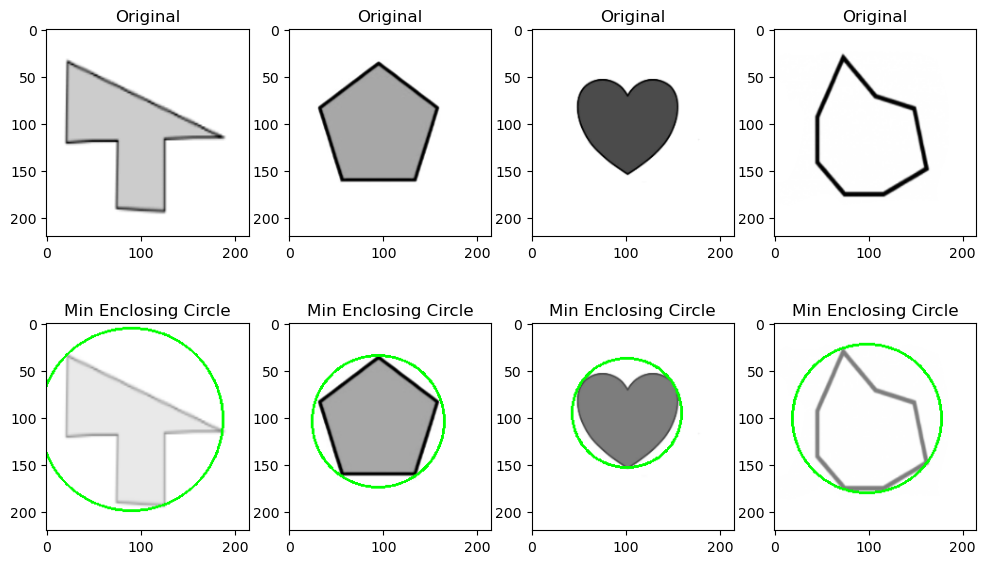

In [17]:
def min_enclosing_circle(image):
    # Threshold the image to binary
    _, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the contour with the largest area
        max_contour = max(contours, key=cv2.contourArea)

        # Compute the minimum enclosing circle for the largest contour
        (x, y), radius = cv2.minEnclosingCircle(max_contour)

        # Convert the center coordinates to integers
        center = (int(x), int(y))
        radius = int(radius)

        # Draw the circle on the original image
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.circle(output, center, radius, (0, 255, 0), 2)

        return output, center, radius
    else:
        # Return a default result if no contours are found
        return image, (0, 0), 0


fig, axes = plt.subplots(2, 4, figsize=(12, 7))
paths=["./shape1.png", "./shape2.png", "./shape3.png", "./shape4.png"]

for i, path in enumerate(paths):
    image = cv2.imread(path, 0)
    image = cv2.resize(image, (215, 220))
    axes[0][i].imshow(image, cmap="gray")
    axes[0][i].set_title('Original')
    output, center, radius = min_enclosing_circle(image)
    axes[1][i].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes[1][i].set_title('Min Enclosing Circle')

plt.show()

### Exercise 5: Bag of Visual Words Pipeline and VOC Dataset Analysis
**Objective**:
Develop a BoVW model and apply it to classify images from the VOC dataset, focusing on the BoVW approach.

**Guideline**:
- Load the VOC dataset.
- Implement the BoVW model.
- Apply the model to the dataset for classification.
- Evaluate the model's performance.

**Expected Results**:
- Implementation of the Bag of Visual Words model.
- Application of the model for image classification.
- Evaluation of the model's performance.

**Optional Enhancements**:
- Experiment with different clustering algorithms for codebook generation in the BoVW model.

### Step 1: Data Loading
- **Objective**: Load images from each class into a format suitable for processing.
- **Guide**: Use a library like OpenCV or PIL in Python to load images. Iterate over the folders, loading each image and storing it with its class label.

### Step 2: Feature Extraction
- **Objective**: Extract features from each image to represent its content.
- **Guide**: Apply a feature descriptor to each image. This transforms the image into a set of features. Examples can be SIFT, SURF, Color histogram, etc

### Step 3: Building the Vocabulary (Codebook)
- **Objective**: Create a vocabulary of visual words (features) that represents the dataset.
- **Guide**: Cluster the extracted features across all images using any clustering algorithm. Each cluster center is a visual word.

### Step 4: Feature Encoding
- **Objective**: Encode each image as a frequency histogram of visual words.
- **Guide**: For each image, count how many features fall into each cluster (visual word) and create a histogram.

### Step 5: Classifier Training
- **Objective**: Train a machine learning model to classify the images.
- **Guide**: Use the histograms as input features for a classifier. Any supervised classifier can be used (SVM, Random Forest, KNN, Neural nets, ...)

### Step 6: Model Evaluation
- **Objective**: Evaluate the performance of the classifier.
- **Guide**: Use a confusion matrix to visualize the performance and extract metrics.

In [18]:
from os import listdir
from os.path import isfile, join
from sklearn.cluster import MiniBatchKMeans
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from skimage.feature import hog

C:\Users\Momo\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [19]:
class_names = ["aquariums", "deserts", "highways", "laundromats", "kitchens", "parks", "waterfalls", "windmills"] # For the plots

cm_list = []
acc_list = []

In [20]:
# Step 1: Data Loading
def load_images(dataset_path):
    images = []
    labels = []
    class_folders = [f for f in listdir(dataset_path) if not isfile(join(dataset_path, f))]

    for i, class_folder in enumerate(class_folders):
        class_folder_path = join(dataset_path, class_folder)
        image_files = [f for f in listdir(class_folder_path) if isfile(join(class_folder_path, f))]
        for image_file in image_files:
            image = cv2.imread(join(class_folder_path, image_file), cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image = cv2.resize(image, (500, 300))  # Resize image
                images.append(image)
                labels.append(i)

    return images, labels

# Step 2: Feature Extraction
def extract_features(image):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT
    kp, des = sift.detectAndCompute(image, None)

    # If des is None, return a 2D array of zeros
    if des is None:
        des = np.zeros((1, sift.descriptorSize()))

    return des

# Parallelize feature extraction
def extract_features_parallel(images):
    return Parallel(n_jobs=-1)(delayed(extract_features)(image) for image in images)

# Step 3: Building the Vocabulary (Codebook)
def build_vocabulary(features, k=10):
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=46)  # Use MiniBatchKMeans
    kmeans.fit(features)
    return kmeans.cluster_centers_

# Step 4: Feature Encoding
def encode_features(image, vocabulary):
    features = extract_features(image)
    histogram = np.histogram(features, bins=len(vocabulary))[0]
    return histogram

# Step 5: Classifier Training
def train_classifier(encoded_features, labels):
    svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))  # C is the regularization parameter
    svc.fit(encoded_features, labels)
    return svc

# Step 6: Model Evaluation
def evaluate_model(classifier, encoded_features, labels, class_names):
    predictions = classifier.predict(encoded_features)
    cm = confusion_matrix(labels, predictions)

    accuracy = accuracy_score(labels, predictions)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return cm, accuracy

Accuracy: 33.75%


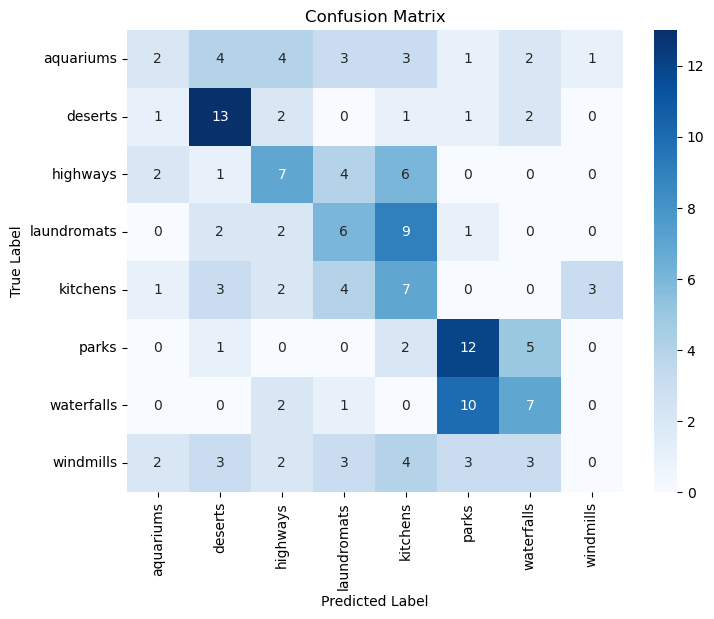

In [21]:
# Load training images
train_images, train_labels = load_images('./dataset/train')
# Extract features
train_features = extract_features_parallel(train_images)
# Build vocabulary
vocabulary = build_vocabulary(np.concatenate(train_features))
# Encode features
train_encoded_features = [encode_features(image, vocabulary) for image in train_images]
# Train classifier
classifier = train_classifier(train_encoded_features, train_labels)
# Load testing images
test_images, test_labels = load_images('./dataset/test')
# Encode test features
test_encoded_features = [encode_features(image, vocabulary) for image in test_images]
# Call evaluate_model with the classifier and other parameters
cm, acc = evaluate_model(classifier, test_encoded_features, test_labels, class_names)
cm_list.append(cm)
acc_list.append(acc)

---
Let's try orb

---

In [22]:
def extract_features(image):
    orb = cv2.ORB_create()

    # Compute ORB keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)

    # If no descriptors are found, return an empty array
    if descriptors is None:
        descriptors = np.empty((0, 32))  # ORB descriptors are 32-dimensional

    return descriptors

Accuracy: 37.50%


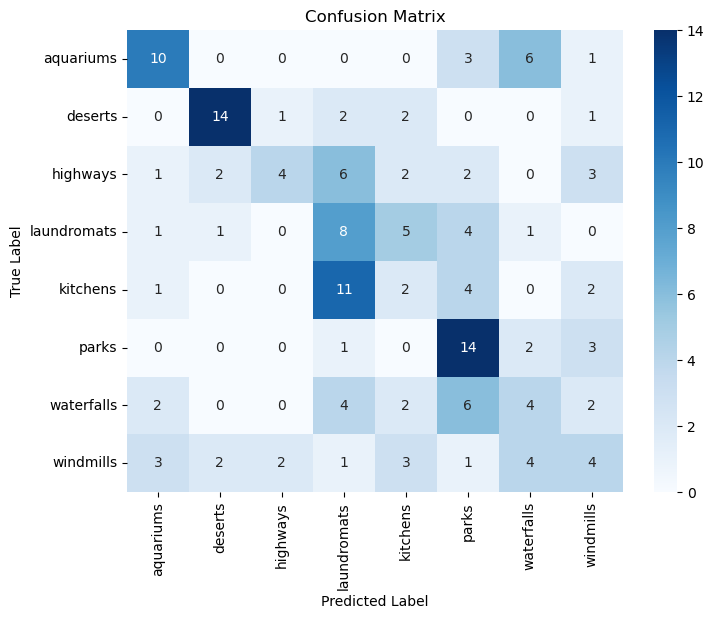

In [23]:
# Load training images
train_images, train_labels = load_images('./dataset/train')
# Extract features
train_features = extract_features_parallel(train_images)
# Build vocabulary
vocabulary = build_vocabulary(np.concatenate(train_features))
# Encode features
train_encoded_features = [encode_features(image, vocabulary) for image in train_images]
# Train classifier
classifier = train_classifier(train_encoded_features, train_labels)
# Load testing images
test_images, test_labels = load_images('./dataset/test')
# Encode test features
test_encoded_features = [encode_features(image, vocabulary) for image in test_images]
# Call evaluate_model with the classifier and other parameters
cm, acc = evaluate_model(classifier, test_encoded_features, test_labels, class_names)
cm_list.append(cm)
acc_list.append(acc)

---
Find the optimal k

---

In [24]:
#!pip install kneed

def optimal (train_features):
    # k_range of k to try
    k_range = range (10, 600, 20)

    # To store the Inertia values
    inertias = []
    for k in k_range:
        kmeans = MiniBatchKMeans (n_clusters=k, random_state=0, n_init='auto').fit(np.concatenate(train_features, axis=0))
        inertias.append (kmeans.inertia_)

    # Plotting the Elbow graph
    plt.plot(k_range, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt. show()

    from kneed import KneeLocator
    knee_locator = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')

    optimal_k = knee_locator.knee
    print(f'Optimal k: {optimal_k}')
    return optimal_k

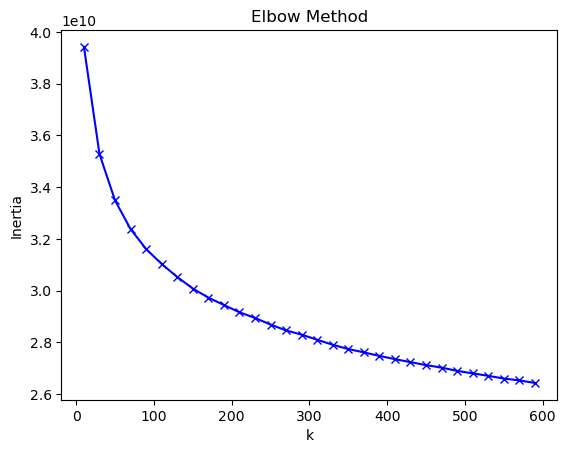

Optimal k: 130
Accuracy: 39.38%


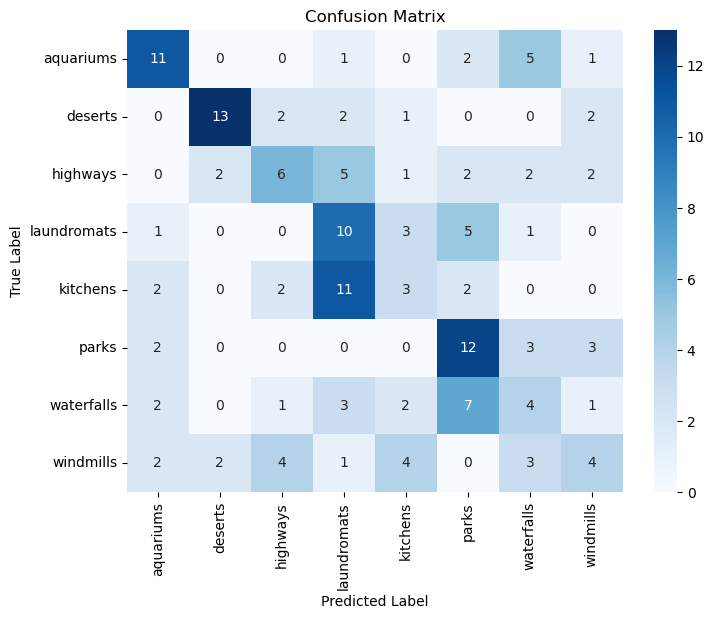

In [25]:
# Load training images
train_images, train_labels = load_images('./dataset/train')
# Extract features
train_features = extract_features_parallel(train_images)

optimal_k = optimal (train_features)

# Build vocabulary
vocabulary = build_vocabulary(np.concatenate(train_features), optimal_k)
# Encode features
train_encoded_features = [encode_features(image, vocabulary) for image in train_images]
# Train classifier
classifier = train_classifier(train_encoded_features, train_labels)
# Load testing images
test_images, test_labels = load_images('./dataset/test')
# Encode test features
test_encoded_features = [encode_features(image, vocabulary) for image in test_images]
# Call evaluate_model with the classifier and other parameters
cm, acc = evaluate_model(classifier, test_encoded_features, test_labels, class_names)
cm_list.append(cm)
acc_list.append(acc)

---
To make it better, i have decided to make these changes:
- orb = cv2.ORB_create(160): The predetermined function is with 128, but when augmenting this parameter, we get better results, specially visible in the diagonal (True Positives)
---

In [26]:
# Step 2: Feature Extraction
def extract_features(image):
    # Initialize ORB feature detector
    orb = cv2.ORB_create(160)
    # Compute ORB keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
    # If no descriptors are found, return an empty array
    if descriptors is None:
        descriptors = np.empty((0, 32))  # ORB descriptors are 32-dimensional
    return descriptors

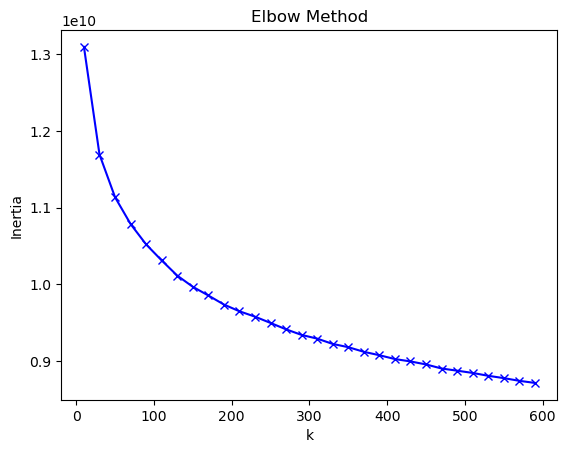

Optimal k: 130
Accuracy: 40.00%


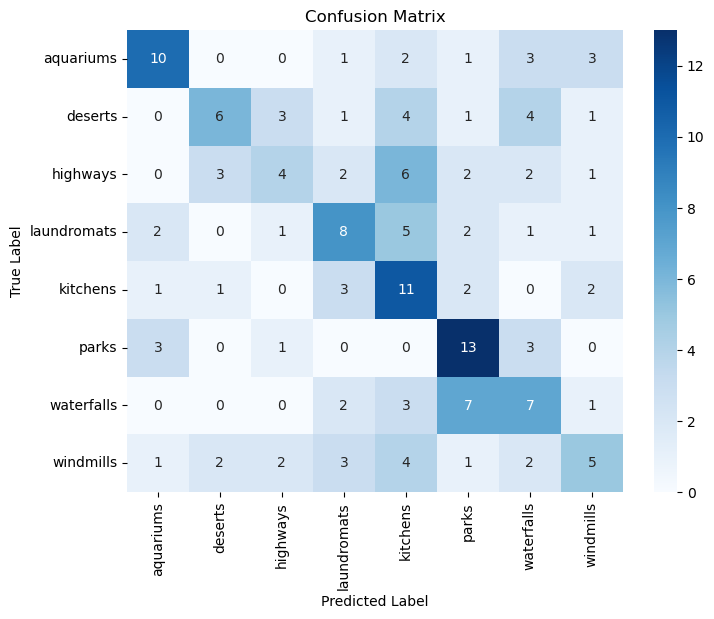

In [27]:
# Load training images
train_images, train_labels = load_images('./dataset/train')
# Extract features
train_features = extract_features_parallel(train_images)

optimal_k = optimal (train_features)

# Build vocabulary
vocabulary = build_vocabulary(np.concatenate(train_features), optimal_k)
# Encode features
train_encoded_features = [encode_features(image, vocabulary) for image in train_images]
# Train classifier
classifier = train_classifier(train_encoded_features, train_labels)
# Load testing images
test_images, test_labels = load_images('./dataset/test')
# Encode test features
test_encoded_features = [encode_features(image, vocabulary) for image in test_images]
# Call evaluate_model with the classifier and other parameters
cm, acc = evaluate_model(classifier, test_encoded_features, test_labels, class_names)
cm_list.append(cm)
acc_list.append(acc)

---
Improvements:
---

Accuracy for matrix 1: 33.75%
Accuracy for matrix 2: 37.50%
Accuracy for matrix 3: 39.38%
Accuracy for matrix 4: 40.00%


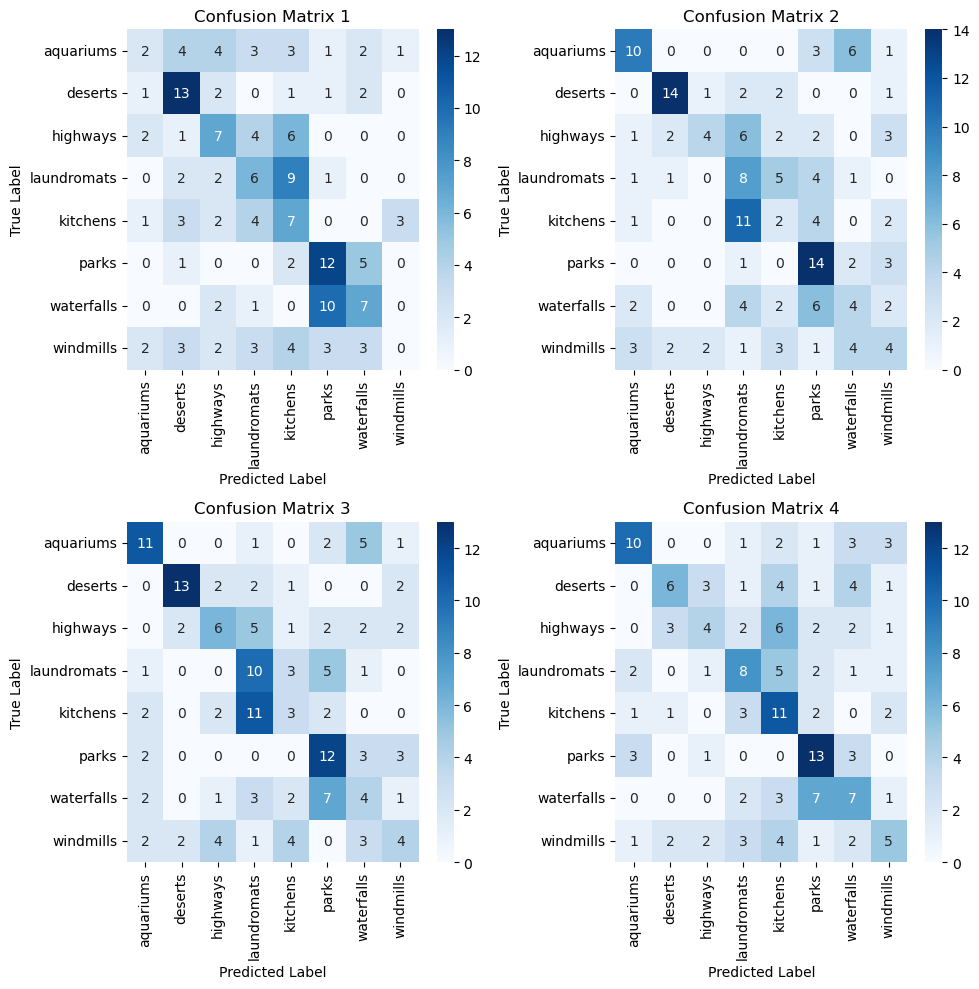

In [28]:
fig, axs = plt.subplots(len(cm_list) // 2, 2, figsize=(10, 10))

for i in range(len(cm_list)):
    row = i // 2
    col = i % 2

    cm = cm_list[i]
    accuracy = acc_list[i]

    print("Accuracy for matrix {}: {:.2f}%".format(i+1, accuracy * 100))

    # Visualize the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axs[row, col])
    axs[row, col].set_title("Confusion Matrix {}".format(i+1))
    axs[row, col].set_xlabel("Predicted Label")
    axs[row, col].set_ylabel("True Label")

plt.tight_layout()
plt.show()